In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


import torch
import numpy as np
from torch.autograd import Variable
from torch.distributions import Normal


class tOU:
    def __init__(self, t0, t1, a, b, c, d, r, sigma, timegrid = False, dN=500):
        """
            t0, t1 = torch.tensor(t1)
            a, b, c, d, r, sigma = torch.tensor.shape (D, 1)
        """
        assert a.shape == b.shape == c.shape == d.shape == r.shape == sigma.shape, "parameters must have the same dimension"
        assert a.shape[1] == 1, "parameter must have a shape D*1"
        assert t0.shape == t1.shape, "t0, t1 must have the same dimension"
        assert all(sigma > 0), "variance must be positive"
        assert all(r > 0), "r must be positive"
        
        self.t0 = t0
        self.t1 = t1
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.r = r
        self.sigma = sigma        
        
        
        D = a.shape[0]
        if timegrid == True:
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
            
        
        self.trj, self.dt = self.path()
            
    def path(self):
        
        # Get parameters
        a = self.a
        b = self.b
        c = self.c
        d = self.d
        r = self.r
        sigma = self.sigma
        
        
        t = self.pts
    
        def mean(x, dt, t0, a, b, c, d, r):
            """
                A mean function is a 3rd power polynomial
                    i.e. m(s) - m(t_)exp(\alpha)
                    where m(s) = as3 + bs2 + cs + d
                t0: we always start our process from t = 0
            """
            s = t0[:, 0].reshape(-1, 1)
            t_ = t0[:, 1].reshape(-1, 1)

            b_term1 = a * (s ** 3) + b * (s ** 2) + c * s + d 
            b_term2 = (a * (t_ ** 3) + b * (t_ ** 2) + c * t_ + d) * torch.exp(r * dt.reshape(-1, 1))
            b_t = b_term1 - b_term2
            
            return (x.reshape(-1, 1) - b_t) * torch.exp(-r * dt.reshape(-1, 1))

        def std(t, r, sigma):
            return torch.sqrt(variance(t, r, sigma))

        def variance(t, r, sigma):
            dt = torch.diff(t)
            return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)


        assert t.shape[1] > 1

        normal = Normal(loc=0., scale=1.)
        x = normal.sample(t.size())
        

        if torch.is_tensor(d):
            x[:, 0] = d.flatten()
        else:
            x[:, 0] = d

        t0 = t - t[:, 0].reshape(-1, 1)

        dt = torch.diff(t)

        scale = std(t, r.reshape(-1,1), sigma.reshape(-1, 1))

        x[:, 1:] = x[:, 1:] * scale
        for i in range(1, x.shape[1]):
            x[:, i] += mean(x[:, i-1], dt[:, i-1], t0[:, i-1:i+1], a, b, c, d, r).flatten()


        return x, dt

def tou_gradient(t, x, params):
    
    """
    Calculates log likelihood of a path
    params = (a, b, c, d, r)
    """
    
    def mean(x, t, a, b, c, d, r):
        """
            t0: we always start our process from t = 0
        """
        t0 = t - t[:, 0].reshape(-1, 1)
        dt = torch.diff(t)
        s = t0[:, :-1]
        t_ = t0[:, 1:]
        
        b_term1 = a * (s ** 3) + b * (s ** 2) + c * s + d 
        b_term2 = (a * (t_ ** 3) + b * (t_ ** 2) + c * t_ + d) * torch.exp(r * dt)
        b_t = b_term1 - b_term2

        return (x - b_t) * torch.exp(-r * dt)
    
    def std(t, r, sigma):
        return torch.sqrt(variance(t, r, sigma))

    def variance(t, r, sigma):
        dt = torch.diff(t)
        return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)

    
    params_ = Variable(params, requires_grad=True)
    a, b, c, d, r, sigma = params_
    
    mu = mean(x[:, :-1], t, a, b, c, d, r)
    var = std(t, r, sigma) + 1e-7 # To prevent the underflow (some of the value becomes 0 due to lack of precision
    
    # from t_1
    LL = torch.sum(Normal(loc=mu, scale=var).log_prob(x[:, 1:]), axis=1)
        
    LL.backward(torch.tensor([1.]).repeat(x.shape[0]))
    return {'a':params_.grad[0].clone().detach(), 'b':params_.grad[1].clone().detach(),
            'c':params_.grad[2].clone().detach(), 'd':params_.grad[3].clone().detach(), 
            'r':params_.grad[4].clone().detach(), 'LL':LL.clone().detach().data}



In [2]:
a = torch.tensor([1., -1]).reshape(-1, 1)
b = torch.tensor([0.5, -1.5]).reshape(-1, 1)
c = torch.tensor([-1., -1]).reshape(-1, 1)
d = torch.tensor([-1., 1]).reshape(-1, 1)
r = torch.tensor([1., 1.]).reshape(-1, 1)
sigma = torch.tensor([1., 1.]).reshape(-1, 1)

In [3]:
t0 = torch.tensor(0.)
t1 = torch.tensor(1.)

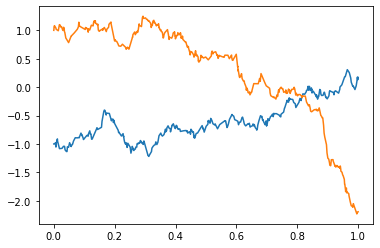

In [4]:
%matplotlib inline

import matplotlib.pylab as plt
tou = tOU(t0, t1, a, b, c, d, r, sigma, timegrid = False, dN=400)
plt.plot(tou.pts.T, tou.trj.T)